# 전체 계획
1. 데이터 로드 & 분리
    * train / test 데이터 분리
2. 탐색적 데이터 분석(EDA)
    * 분포확인 & 이상치 확인
3. 데이터 전처리
    * 이상치 제거
        - 범주형은 딱히 이상치라고 판단할 일이 없을 테니 수치형에 대해서만 생각해보면
        - 그리고 만약 이상치 제거했으면 꼭 index 리셋해주기
    * 데이터 비율 맞춰주기 위해 Oversampleing
        - 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
        - SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용
    * 결측치 처리 (참고로 test 데이터 기준으로는 데이터 총 31647, 전체 데이터로는 45211)
        - 수치형: contact(9100), poutcome(25917)
        - 범주형: job(206), education(1314)
        - 삭제 : -  
        처리하기 애매하다는 느낌 일단 내버려두고 차차 더 생각
    * 전처리
        - 수치형: 'age','balance','day_of_week','duration','campaign','pdays','previous'
        - 범주형: 'job','marital','education','default','housing','loan','contact','month','poutcome'
            - 레이블 인코딩: 
            - 원- 핫 인코딩: 
    
4. 모델 수립
5. 평가

# 데이터 불러오기, X, y 나누기

In [1]:
#기본 모듈 불러오기 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

# 아래에서 따로 이용하는 모듈
from matplotlib.ticker import MultipleLocator
import math
from imblearn.over_sampling import SMOTENC

# # warning을 모두 무시하는 것은 좋지 않으나 과제 수행을 쉽게할 수 있도록 무시설정
# import warnings
# warnings.filterwarnings(action='ignore')

# 그래프 한글 깨지는 것 방지
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

처음에는 ID에 대해서는 따로 쓰이지 않을 것이니 인덱스로 사용하자 했는데 그로 인해서 경고가 너무 많이 발생하는 듯하여    
다시 원래의 기본 인덱스를 사용하여야 할 듯하며, ID는 학습할 때 굳이 필요없으니 train과 test데이터 df에서 제외시켜주도록하였다   
나중에 정렬을 한다던가하여 필요한 일이 생긴다면 다시 가져와야 할 수도 있다

In [2]:
train_df = pd.read_csv('./train.csv') # 첫번째 열인 ID를 index로 사용 ->부분 다시 제외
X_real_test = pd.read_csv('./test.csv') # 첫번째 열인 ID를 index로 사용 ->부분 다시 제외

# # ID열 제거 -> # 생각해보니 학습할 때 선택할 컬럼에 넣지만 않으면 그대로 둬도 상관 없을 것 같음
# train_df = train_df.drop(columns='ID')
# X_real_test = X_real_test.drop(columns='ID')

# X, y 분리
def reset_X_y(dataframe:pd.DataFrame = train_df, y_col='대출등급'):
    X = dataframe.drop(columns=[y_col])
    y = dataframe[[y_col]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = reset_X_y()

# 후에 살펴보고 싶은 행에 해당하는 데이터 불러올 때 인덱스 또는 인덱스로 쓸 수 있는 id불러와야하는데 id는 제외시켜줬고 인덱스는 분리하면서 섞인듯하여 리셋해줌
# ->일단 아이디를 다시 살려서 안해도 되지 않을까..?하는 생각이 들어서 일단 안함
# for data in [X_train, X_test, y_train, y_test]:
#     data.reset_index()

numeric_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
category_col = ['대출기간', '근로기간', '주택소유상태', '대출목적']
# train_df.iloc[[42717,82476,21126]] 기존 탑 3개 인덱스들

In [3]:
display(X_train.head(3))
y_train.head(3)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
42717,TRAIN_42717,30000000,60 months,1 year,MORTGAGE,60000000,27.47,17,부채 통합,0,805248,1743384.0,0.0,0.0
82476,TRAIN_82476,6000000,36 months,10+ years,RENT,81600000,30.77,25,신용 카드,0,291972,87528.0,0.0,0.0
21126,TRAIN_21126,12000000,36 months,10+ years,MORTGAGE,60000000,37.64,32,부채 통합,0,564216,211788.0,0.0,0.0


,대출등급
42717,F
82476,B
21126,B


# EDA

## y값 비율 확인해보기
- 비율 상으로 비슷하게 존재하지 않아서 낮은 E?,F,G 정도 oversampleing해야할 수도 있는데 일단 그냥 안하고 해봄

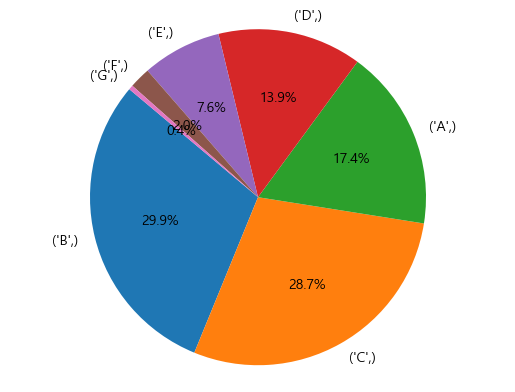

In [4]:
y_train_counts = y_train.value_counts()
plt.pie(y_train_counts, labels=y_train_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 원형을 유지하도록 하는 옵션
plt.show()

## 결측치 확인
- 근로기간에 'Unknown' 이라고 결측치가 5671개 존재

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


In [6]:
train_df.isna().sum()

ID              0
대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
대출등급            0
dtype: int64

In [7]:
for column in X_train.columns:  # 근로기간에 Unkown으로 결측치 있음
    unknown_count = (X_train[column] == 'Unknown').sum()
    print(f"{column}: {unknown_count}")

ID: 0
대출금액: 0
대출기간: 0
근로기간: 3971
주택소유상태: 0
연간소득: 0
부채_대비_소득_비율: 0
총계좌수: 0
대출목적: 0
최근_2년간_연체_횟수: 0
총상환원금: 0
총상환이자: 0
총연체금액: 0
연체계좌수: 0


## 기술통계를 통한 EDA

In [8]:
train_df.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [9]:
train_df.describe(include='O')

,ID,대출기간,근로기간,주택소유상태,대출목적,대출등급
count,96294,96294,96294,96294,96294,96294
unique,96294,2,16,4,12,7
top,TRAIN_00000,36 months,10+ years,MORTGAGE,부채 통합,B
freq,1,64479,31585,47934,55150,28817


In [10]:
# display(train_df[train_df['연간소득']==0])

## 시각화를 통한 EDA

### 수치형 데이터 시각화

In [11]:
for check_col in ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']:
    # print(check_col, " : ", len(set(X_train[check_col]))) # 중복없이 값종류 갯수
    print(check_col, " : ", len(X_train[check_col].unique())) # 중복없이 값종류 갯수

대출금액  :  1321
연간소득  :  5806
부채_대비_소득_비율  :  3993
총계좌수  :  106
최근_2년간_연체_횟수  :  20
총상환원금  :  21977
총상환이자  :  28445
총연체금액  :  78
연체계좌수  :  4


대출금액  bin :  61
연간소득  bin :  100
부채_대비_소득_비율  bin :  100
총계좌수  bin :  224
최근_2년간_연체_횟수  bin :  20
총상환원금  bin :  100


C:\Users\kssg1\AppData\Local\Temp\ipykernel_11740\1436924818.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  num_bin = entire_range / bin_width


총상환이자  bin :  265
총연체금액  bin :  18
연체계좌수  bin :  4


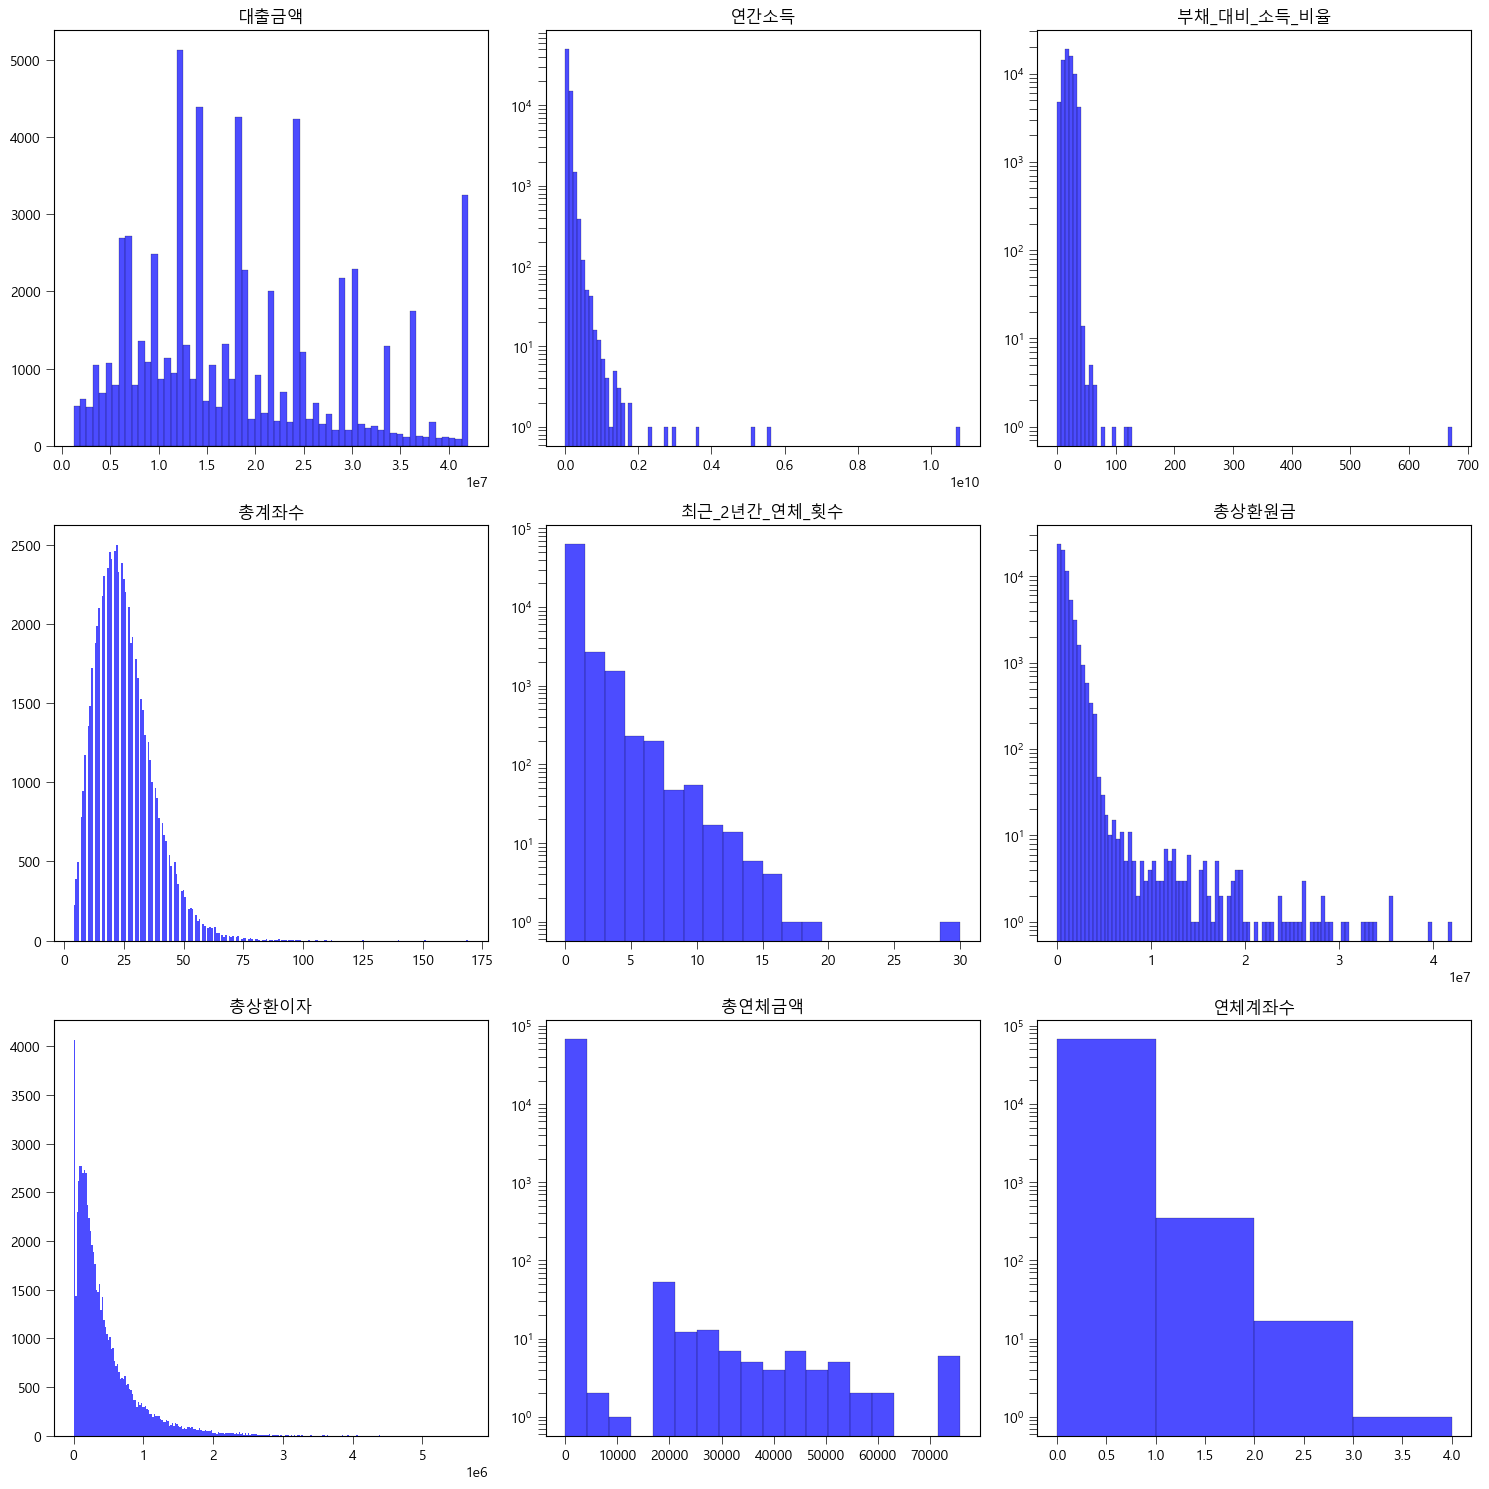

In [12]:
#수치형 변수 시각화
def get_3_hist_num(data:pd.DataFrame, columns:list, whether_log_scale: bool = True, 
                                        log_scale_threshold: float = 5000, bin_control: bool =True, num_bin_max: int = 300, num_bin_set: int = 80):
    """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

    Args:
        data (pd.DataFrame): 데이터프레임
        columns (list): 컬럼 리스트
        bar_width_ratio(float): 원하는 비율로 설정 (예시로 0.005 사용)
    """
    num_plots = len(columns)
    num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
    num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, col in enumerate(columns):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()
        n_bins = 'auto'
        
        if bin_control == True :
            # Freedman-Diaconis' Choice방식으로 bin 갯수 얼추 계산해본 뒤 판단
            entire_range = X_train[col].max() - X_train[col].min() # 데이터 값 최대와 최소 차이
            q1 = np.percentile(X_train[col], 25)
            q3 = np.percentile(X_train[col], 75)
            IQR = q3 - q1
            N = X_train[col].count()
            bin_width = 2 * (IQR / N**(1/3))
            num_bin = entire_range / bin_width
            # print(col, "의 bin : ", num_bin) # 점검용
            if len(set(data[col])) <= 20:
                n_bins = len(set(data[col]))
            elif (not math.isinf(num_bin)) and num_bin > num_bin_max:
                n_bins = num_bin_set
            else:
                n_bins = 'auto' # 지워도 괜찮을듯
        
        # # Wand 규칙을 사용하여 동적으로 bin의 개수 설정
        # if bar_width_ratio < bar_width_ratio_min:  # 전체 스케일에 대한 막대 두께의 비율이 너무 작으면
        #     n_bins = int(np.sqrt(len(set(data[col])))*1.0) 
        #     # 조금더 줄이면 깔끔히 잘보이지 않을까해서 0.8곱했다가 별차이없는듯해서 1.0으로 원 위치(원래 곱해진 것 따로 없었음)
        # else:
        #     n_bins = 'auto'
            
        hist, bins, _ = axes[row_idx, col_idx].hist(data[col], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7)
        num_bin_actual = len(bins) - 1  # 실제로 그려진 막대의 갯수
        #sns.histplot(data[col], ax=axes[row_idx, col_idx], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7, kde=False)
        
        axes[row_idx, col_idx].set_title(col)
        axes[row_idx, col_idx].tick_params(axis='both', which='both', direction='out', length=6, width=0.5)  # 눈금 표시
        
        bar_heights = [rect.get_height() for rect in axes[row_idx, col_idx].patches]
        max_height = max(bar_heights)
        min_height = max(min(bar_heights),1)
        
        # print(col, " 높이차는 이러함 : ", max_height / min_height, max_height, min_height) # 점검용
        print(col, " bin : ", num_bin_actual) # 점검용
        
        # 히스토그램 바의 높이 차이에 따라 리니어 스케일 또는 로그 스케일 선택
        if whether_log_scale == True and (max_height / min_height) > log_scale_threshold:
            axes[row_idx, col_idx].set_yscale('log')  # 로그 스케일로 변환
        else:
            axes[row_idx, col_idx].set_yscale('linear')  # 리니어 스케일로 유지
        
        # 전체 그래프 스케일에 대한 막대 자체의 두께 비율 계산
        total_width = axes[row_idx, col_idx].get_xlim()[1] - axes[row_idx, col_idx].get_xlim()[0]
        
        
        
        # 히스토그램 바의 두께가 조건에 따라 테두리 색 설정
        for rect in axes[row_idx, col_idx].patches:
            bar_width = rect.get_width()
            if bar_width / total_width > 0.005: # 그냥 저쯤보다 얇은 경우 테두리 없는게 나은듯해서 설정해줌
                rect.set_edgecolor('black')
            else:
                rect.set_edgecolor('none')  # 얇은 경우에는 테두리 없애기
        
        # # Seaborn axis 객체로부터 눈금 위치 확인
        # tick_locs = sns.histplot(data[col]).axes.get_xticks()
        # print(f"{col}의 현재 x 축 눈금 위치: {tick_locs}")

    # 남은 서브플롯에 빈 그래프 그리기
    for i in range(num_plots, num_rows * num_cols):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()  # 남은 서브플롯 비우기
        axes[row_idx, col_idx].axis('off')  # 빈 서브플롯 제거
        
    

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()
get_3_hist_num(X_train, numeric_col, log_scale_threshold=8000, num_bin_max=270, num_bin_set=100)

<Axes: xlabel='총상환이자', ylabel='Count'>

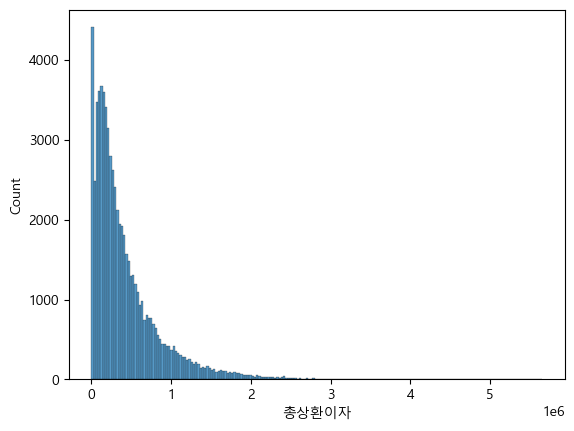

In [13]:
sns.histplot(X_train, x='총상환이자', bins=200)

In [14]:
X_train['총상환이자'].value_counts()

총상환이자
0.0          3755
156144.0       54
209880.0       49
233904.0       48
99312.0        47
             ... 
1397040.0       1
553308.0        1
488268.0        1
599868.0        1
922020.0        1
Name: count, Length: 28445, dtype: int64

In [15]:
X_train[X_train['부채_대비_소득_비율']>2000]['부채_대비_소득_비율'].value_counts() # -> 이상치로 판단

Series([], Name: count, dtype: int64)

In [16]:
print(X_train[X_train['최근_2년간_연체_횟수']==0]['최근_2년간_연체_횟수'].value_counts())
print(X_train[X_train['최근_2년간_연체_횟수']>0]['최근_2년간_연체_횟수'].value_counts())

최근_2년간_연체_횟수
0    53384
Name: count, dtype: int64
최근_2년간_연체_횟수
1     9225
2     2704
3     1021
4      502
5      227
6      137
7       59
8       47
10      28
9       27
11      17
12       7
13       7
14       6
16       3
18       1
15       1
17       1
30       1
Name: count, dtype: int64


In [17]:
X_train[X_train['총연체금액']<1]['총연체금액'].count()

67282

#### 판단
- '연간소득': 로그스케일 고려할 필요 없을듯 최소랑 최대랑 그리 막 차이 나진 않아서
- '부채_대비_소득_비율': 9999.0으로 이상치 하나 있는 것으로 판단됨
- '최근_2년간_연체_횟수': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, log스케일은 할 필요 없을듯, 17이후 30이라 30을 이상치로 볼지는 염두만
- '총상환원금': 로그스케일 고려할 필요 없을듯 최소랑 최대랑 그리 막 차이 나진 않아서
- '총상환이자': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, 로그스케일 고려할 필요 없을듯 최소랑 최대랑 그리 막 차이 나진 않아서
- '총연체금액': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, 로그스케일 고려
- '연체계좌수': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>


### 범주형 데이터 시각화

In [18]:
# # 범주형 변수 시각화(countplot) # 개선 필요
# def get_3_countplot_category(data:pd.DataFrame, columns:list, log_scale_threshold: float = 5000):
#     """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

#     Args:
#         data (pd.DataFrame): 데이터프레임
#         columns (list): 컬럼 리스트
#         bar_width_ratio(float): 원하는 비율로 설정 (예시로 0.005 사용)
#     """
#     num_plots = len(columns)
#     num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
#     num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
#     for i, col in enumerate(columns):
#         if num_rows == 1:
#             col_idx = i  # 수정된 부분
#             axes[col_idx].clear()
#             n_bins = 'auto'
#             sns.countplot(data=data, x=col, ax=axes[col_idx])  # 수정된 부분
#             max_length = max(data[col].astype(str).apply(len))  # 열의 최대 길이 계산
#             if max_length > 10:
#                 for tick in axes[col_idx][0].get_xticklabels():
#                     tick.set_rotation(45)  # 값이 10글자 이상인 경우 rotation=45 적용
#         else:
#             row_idx, col_idx = divmod(i, 3)
#             axes[row_idx, col_idx].clear()
#             n_bins = 'auto'
#             sns.countplot(data=data, x=col, ax=axes[row_idx, col_idx])
#             max_length = max(data[col].astype(str).apply(len))  # 열의 최대 길이 계산
#             if max_length > 10:
#                 for tick in axes[col_idx][0].get_xticklabels():
#                     tick.set_rotation(45)  # 값이 10글자 이상인 경우 rotation=45 적용

#     # 전체 그림 표시
#     plt.tight_layout()
#     plt.show()
# get_3_countplot_category(X_train, category_col)

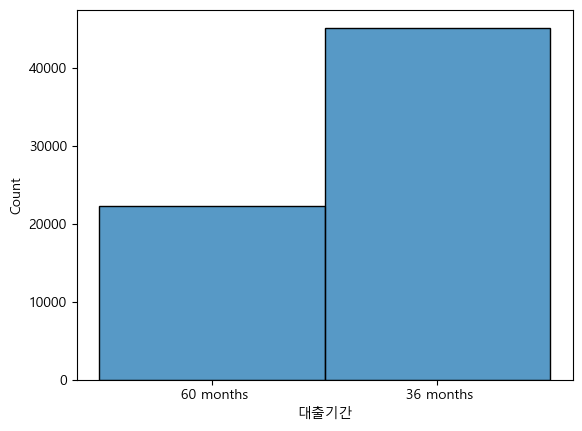

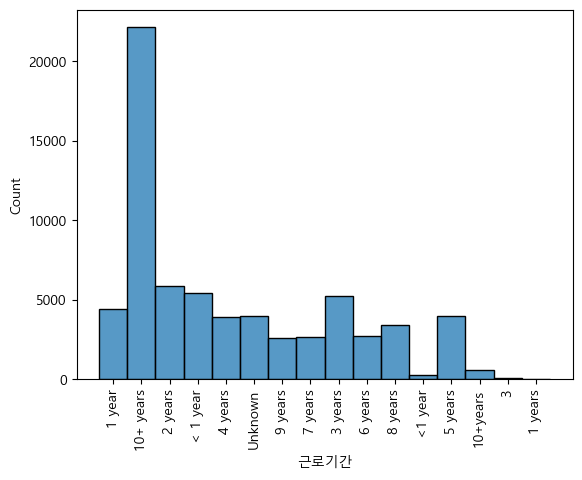

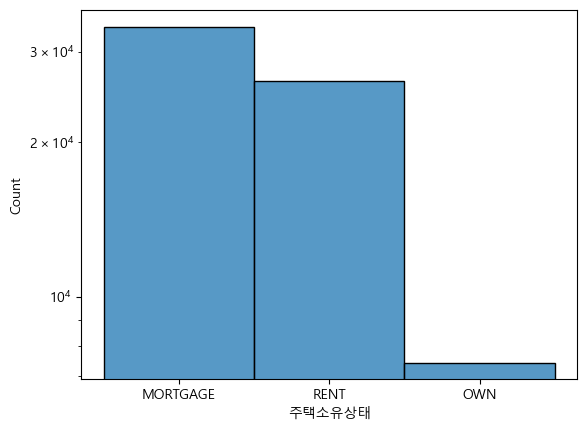

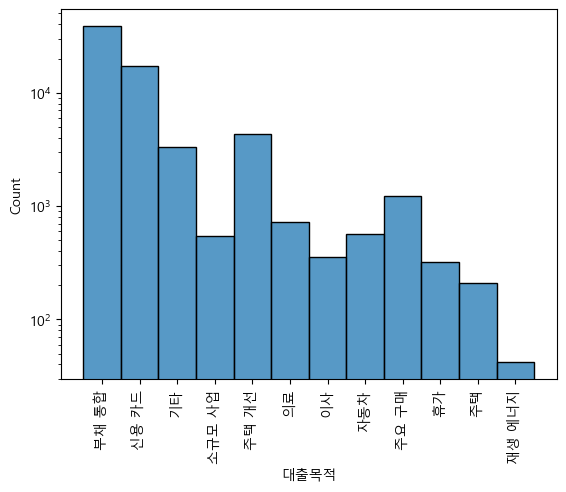

In [19]:
for plot_col in category_col:
    sns.histplot(X_train, x=plot_col)
    if plot_col in ['근로기간', '대출목적']:
        plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
    if plot_col in ['주택소유상태', '대출목적']:
        plt.yscale('log')  # y축을 로그 스케일로 변환
    plt.show()

In [20]:
X_train['근로기간'].unique()

array(['1 year', '10+ years', '2 years', '< 1 year', '4 years', 'Unknown',
       '9 years', '7 years', '3 years', '6 years', '8 years', '<1 year',
       '5 years', '10+years', '3', '1 years'], dtype=object)

#### 근로기간에 잘못 적힌 값이 많은듯 
- 10+years를 10+ years 로 통일시켜주기
- < 1 year를 <1 year로 통일시켜주거나, 아니면 0 year로 통일시켜주기
- 1 years를 1 year로 통일시켜주기
- 3을 3 years로 통일시켜주기


In [21]:
X_train[X_train['주택소유상태']=='ANY']['주택소유상태'].count()

0

#### 주택소유상태 표시 의미
주택 소유 상태를 나타내는 단어에서 각각의 의미는 다음과 같습니다:

RENT (임대): 주택을 소유하지 않고 대신 임대(또는 전세)하는 상태를 나타냅니다. 임차인은 일정 기간 동안 주택을 사용할 수 있지만 소유권은 없습니다.    
MORTGAGE (담보): 주택을 구매하기 위해 대출을 받고, 그 주택을 담보로 제공하는 상태를 나타냅니다. 대출을 상환하면서 주택의 소유권은 점차 대출을 상환하는 사람(대출자)에게 이전됩니다.     
OWN (소유): 주택을 소유하고 있는 상태를 나타냅니다. 소유자는 주택의 완전한 소유 및 권한을 가지며, 언제든지 주택을 판매하거나 대여할 수 있습니다.    
ANY (어느 것도 아닌): "ANY"는 일반적으로 선택지가 없음을 나타내며, 주택 소유 상태를 명시적으로 나타내지 않는 경우에 사용될 수 있습니다. 

In [22]:
X_train[X_train['대출목적']=='재생 에너지']['대출목적'].count()

42

# 데이터 전처리
- 이상치
	- 부채_대비_소득_비율 9999.0로 이상치 하나 존재 제거
- 결측치
	- 근로기간 결측치 Unknown 처리 고민 , Unkown형태는 없었지만 더 확인해볼 필요는 있을듯
- 값 형식 불일치
	- 근로기간 값 형식이 일치 안된 것이 많아서
		- 10+years를 10+ years 로 통일시켜주기
		- < 1 year를 <1 year로 통일시켜주거나, 아니면 0 year로 통일시켜주기
		- 1 years를 1 year로 통일시켜주기
		- 3을 3 years로 통일시켜주기
- 데이터 형식 바꿔주기
	- 범주형 데이터 object에서 category로 형식 변경, 그리고 카테고리 순서정해줄 것은 순서 정해주기
- 데이터 비율 맞춰주기 위해 Oversampleing
	- 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
    - SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용
- 컬럼 분리
	- 최근_2년간_연체_횟수, 총상환이자, 총연체금액, 연체계좌수 : 0인 것과 아닌 것 구분해서 범주컬럼으로 추가해주기

- 스케일링
	- 수동 로그스케일링:
		- 총연체금액: 로그스케일링해주기
- 인코딩
	- 순서 인코딩:
	- 레이블 인코딩: 대출기간, 근로기간
	- 원-핫 인코딩 : 주택소유상태, 대출목적
		- get_dummy:
		- 원-핫 인코딩:

## 이상치 제거
- 부채_대비_소득_비율 9999.0로 이상치 하나 존재 제거

In [23]:
# 2000이상으로 값이 9999.0 하나 밖에 존재하지 않음
# 제거하고 나도 조금 떨어져 있는 듯한 녀석들이 있어서 전에 전처리 개인과제때 이상치 제거 함수 가져와서 통계적인 방법으로 이상치 제거하는게 나을듯
def to_remove_Outlier(data:pd.DataFrame = X_train): # train 데이터에 대해서만 해주면 될듯
    data = data[data['부채_대비_소득_비율']<3000] #<600
    return data
X_train = to_remove_Outlier(X_train) # 이건 또 지역변수로 되었는지 값 반영안되서 반영

In [24]:
X_train.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,6.740500e+04,6.740500e+04,67405.000000,67405.000000,67405.000000,6.740500e+04,6.740500e+04,67405.000000,67405.000000
mean,1.831606e+07,9.377144e+07,19.252795,25.299132,0.349336,8.259179e+05,4.292798e+05,53.806038,0.005771
std,1.034541e+07,8.462993e+07,9.091606,12.106090,0.931287,1.064245e+06,4.418538e+05,1426.305294,0.080127
min,1.200000e+06,1.440000e+06,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.660000,17.000000,0.000000,3.078480e+05,1.353480e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.720000,24.000000,0.000000,5.986800e+05,2.873400e+05,0.000000,0.000000
75%,2.400000e+07,1.123200e+08,25.480000,32.000000,0.000000,1.055076e+06,5.702280e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,672.520000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [25]:
# X_train['부채_대비_소득_비율'].skew()

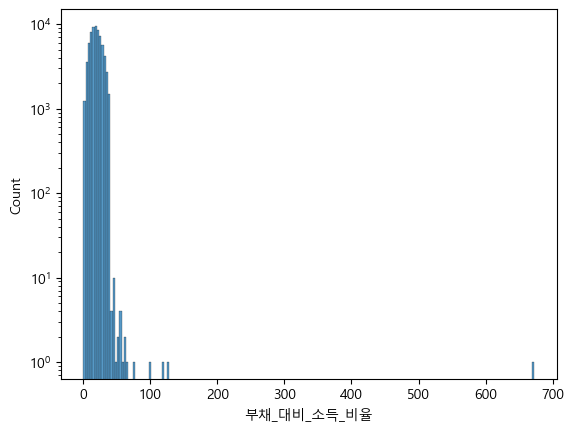

In [26]:
# 이상치 제거후 확인
sns.histplot(data=X_train, x='부채_대비_소득_비율', bins=200)
plt.yscale('log')
plt.show()

##  결측치 처리
- 제거하거나 최빈값으로 대치해주면 될듯하나 일단 패스
- 근로기간 결측치 Unknown 처리 고민 , Unkown형태는 없었지만 더 확인해볼 필요는 있을듯
    - 각 범주의 갯수의 평균 약 6018인데 Unknown의 갯수는 5670 이며  
        대략 확 차이나는 것이 3744와 896으로 확 뛰어서 3000개 이상인 것들에 대해서만 평균 내면 약 7907임    
        총 96293개 중 5670개이므로 5.89%정도 됨

In [27]:
(5670/X_train['근로기간'].count())*100

8.41183888435576

In [28]:
# '근로기간' 열의 값 빈도 계산
value_counts = X_train['근로기간'].value_counts()
print("값의 빈도:", value_counts)
# 빈도가 3000개를 초과하는 값을 선택하여 출력
selected_values = value_counts[value_counts > 3000]
print("3000개를 초과하는 값들:")
print(selected_values)
print("3000개 초과하는 값들의 평균:", selected_values.mean())

값의 빈도: 근로기간
10+ years    22133
2 years       5904
< 1 year      5430
3 years       5274
1 year        4430
5 years       3973
Unknown       3971
4 years       3912
8 years       3439
6 years       2703
7 years       2681
9 years       2599
10+years       591
<1 year        259
3               71
1 years         35
Name: count, dtype: int64
3000개를 초과하는 값들:
근로기간
10+ years    22133
2 years       5904
< 1 year      5430
3 years       5274
1 year        4430
5 years       3973
Unknown       3971
4 years       3912
8 years       3439
Name: count, dtype: int64
3000개 초과하는 값들의 평균: 6496.222222222223


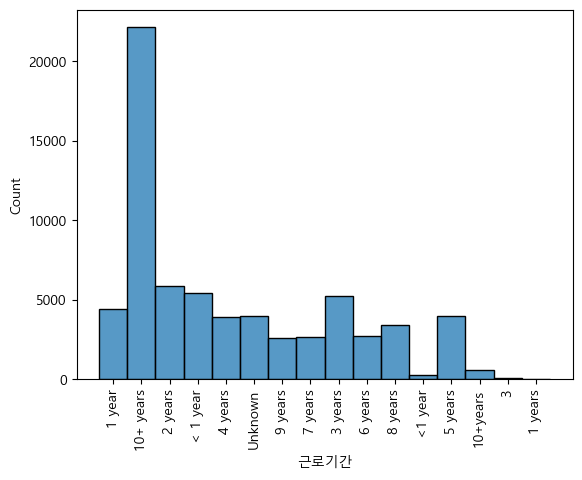

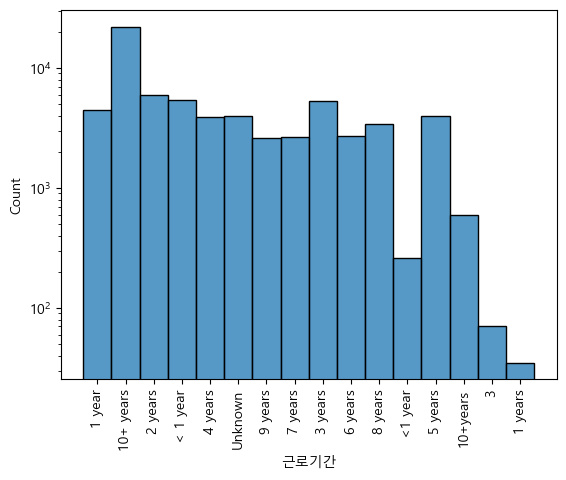

In [29]:
# 근로기간 값 확인용 그래프 두가지
sns.histplot(X_train, x='근로기간')
plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
plt.show()
sns.histplot(X_train, x='근로기간')
plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
plt.yscale('log')  # y축을 로그 스케일로 변환
plt.show()

In [30]:
def get_non_missing(data:pd.DataFrame = X_train, option:int = 1):
    if option == 1: # 제거방식
        data=data[data['근로기간'] != 'Unknown']
    elif option == 2:
        print("아직 구현중")
    

## 값 형식 불일치 통일시켜주기
- 근로기간 값 형식이 일치 안된 것이 많아서
    - 10+years를 10+ years 로 통일시켜주기
    - < 1 year를 <1 year로 통일시켜주거나, 아니면 0 year로 통일시켜주기
    - 1 years를 1 year로 통일시켜주기
    - 3을 3 years로 통일시켜주기
- 추가로 값 형식 적당히 정해주고 맞지 않는 값이 존재하는지 확인하는 함수(아직 구현 X, 계획 되어있음)

In [31]:
def fu_근로기간(value) :
    if value == '10+years':
        return '10+ years'
    elif value == '< 1 year':
        return '<1 year'
    elif value == '1 years':
        return '1 year'
    elif value == '3':
        return '3 years'
    else: # 조건에 해당하지 않는 옳은 값의 경우 그대로 값 리턴
        return value

#X_train['근로기간'] = X_train['근로기간'].apply(fu_근로기간)

def Formal_unification(data:pd.DataFrame = X_train, col_list=['근로기간']):
    for col in col_list:
        func = globals().get(f"fu_{col}")  # 함수 이름 동적으로 가져오기
        if func: # 만약 해당되는 함수가 없을 경우를 방지하기 위해 if추가
            data.loc[:, col] = data[col].apply(func) # data[col] = data[col].apply(func) # 경고 떠서 해결하기 위해
    return data

# 범주 값 가져와서 그외 정해놓은 형식에 어긋나는 컬럼 있는지 체크하는 함수
# 아직 안만듦 만들예정

Formal_unification(X_train)
Formal_unification(X_test) # test data에 대해서도 값형식 통일 안된 경우 확인 # 이건 또 따로 값 저장안해줘도 전역변수로 인식한듯

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
57104,TRAIN_57104,5760000,36 months,<1 year,RENT,78000000,15.69,33,신용 카드,0,397428,179040.0,0.0,0.0
42625,TRAIN_42625,12000000,36 months,10+ years,RENT,60000000,11.19,22,신용 카드,0,0,0.0,0.0,0.0
84000,TRAIN_84000,9600000,36 months,2 years,MORTGAGE,42000000,25.15,23,신용 카드,0,0,0.0,0.0,0.0
19240,TRAIN_19240,18000000,36 months,Unknown,MORTGAGE,77520000,23.65,21,주택 개선,0,1355280,365724.0,0.0,0.0
5174,TRAIN_05174,6000000,36 months,Unknown,RENT,24000000,8.76,12,부채 통합,0,279768,86964.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,TRAIN_01962,5400000,36 months,1 year,OWN,30000000,10.32,12,신용 카드,0,401292,105264.0,0.0,0.0
12349,TRAIN_12349,14400000,36 months,9 years,RENT,144000000,22.74,56,주요 구매,0,665028,290916.0,0.0,0.0
85081,TRAIN_85081,10320000,36 months,10+ years,MORTGAGE,56400000,29.12,33,신용 카드,0,788340,153336.0,0.0,0.0
80234,TRAIN_80234,14400000,36 months,3 years,RENT,54000000,20.99,20,신용 카드,0,1070124,280680.0,0.0,0.0


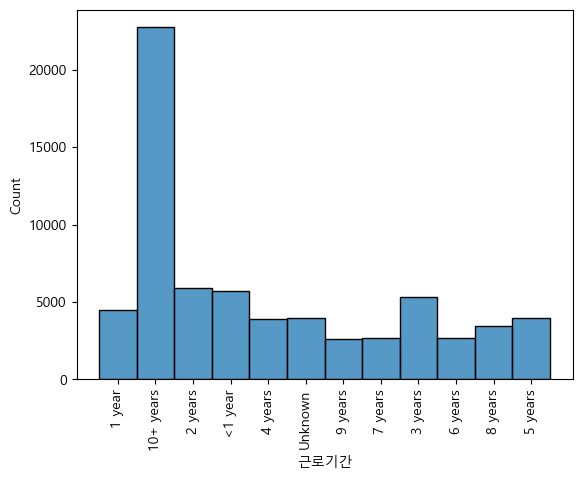

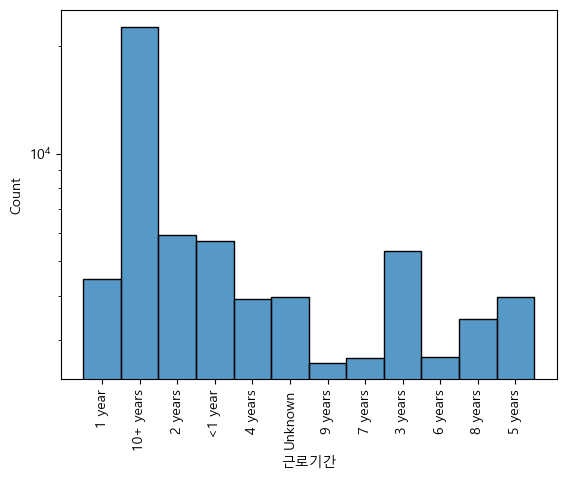

In [32]:
# 근로기간 값 확인용 그래프 두가지
sns.histplot(X_train, x='근로기간')
plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
plt.show()
sns.histplot(X_train, x='근로기간')
plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
plt.yscale('log')  # y축을 로그 스케일로 변환
plt.show()

## 데이터 형식 바꿔주기
- 범주형 데이터 object에서 category로 형식 변경, 그리고 카테고리 순서정해줄 것은 순서 정해주기
- 현재 경고가 좀 뜨는데 일단 가동자체는 문제가 없으니 후에 개선하겠음

In [33]:
# 함수화
def type_change_category(data:pd.DataFrame, columns:list):
    for col in columns:
        data[col] = data[col].astype('category')
        # ordered=False로 해주어 순서를 정해주되, 변수 자체에 순서내용까지는 포함시키지 않았다 
        # True로 하니까 무슨 <이런식으로 내용추가되는듯했음
        if col == '대출기간':
            loan_period_list = [' 36 months', ' 60 months']
            data[col] = data[col].cat.reorder_categories(loan_period_list, ordered=False)
        elif col == '근로기간':
            working_period_list = ['Unknown', '<1 year', '1 year', '2 years', '3 years', '4 years', 
                             '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'] #미혼, 기혼, 이혼 순으로 순서 정해줬음
            data[col] = data[col].cat.reorder_categories(working_period_list, ordered=False)
        elif col == '대출등급':
            loan_rating_list = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
            data[col] = data[col].cat.reorder_categories(loan_rating_list, ordered=False)
    return None

# X_train
type_change_category(X_train, category_col) #얘들도 알아서 전역변수로 인식되어 잘 반영되었음
# X_test
type_change_category(X_test, category_col)
# y_train
type_change_category(y_train, ['대출등급'])

In [34]:
print(X_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 67405 entries, 42717 to 33408
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ID            67405 non-null  object  
 1   대출금액          67405 non-null  int64   
 2   대출기간          67405 non-null  category
 3   근로기간          67405 non-null  category
 4   주택소유상태        67405 non-null  category
 5   연간소득          67405 non-null  int64   
 6   부채_대비_소득_비율   67405 non-null  float64 
 7   총계좌수          67405 non-null  int64   
 8   대출목적          67405 non-null  category
 9   최근_2년간_연체_횟수  67405 non-null  int64   
 10  총상환원금         67405 non-null  int64   
 11  총상환이자         67405 non-null  float64 
 12  총연체금액         67405 non-null  float64 
 13  연체계좌수         67405 non-null  float64 
dtypes: category(4), float64(4), int64(5), object(1)
memory usage: 5.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 67405 entries, 42717 to 33408
Data columns (total 1 columns):
 

## 데이터 비율 맞춰주기 위해 Oversampleing
- 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
- SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용

In [35]:
# smnc = SMOTENC(categorical_features=category_col, random_state=42)
# X_train, y_train = smnc.fit_resample(X_train, y_train)
# # X_test, y_test = smnc.fit_resample(X_test, y_test) # 테스트 데이터는 건드리면 안될 것이라 판단되서 제외함

### oversampling한 뒤 결과 데이터 확인하기

In [36]:
# X_train.info()
# print(X_train.isna().sum())
# display(X_train.describe())
# display(X_train.describe(include=['category']))
# X_train.describe(include = 'all')

## 컬럼 분리 (0인 것과 아닌 것 구분해서 범주컬럼으로 추가해주기)
- 최근_2년간_연체_횟수, 총연체금액, 연체계좌수 -> 셋다 같은 결과를 가져올듯함
- 연간소득, 부채_대비_소득_비율, 총상환원금, 총상환이자 는 최소가 0이 있긴한데 굳이 안해줘도 될듯
주의! 이건 아직 함수화 안 시켜둿음 할지 말지는 더 고민해봐야할듯    
마찬가지로 경고가 조금 많이 뜨는데 후에 개선해주겠음

In [37]:
X_train.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,6.740500e+04,6.740500e+04,67405.000000,67405.000000,67405.000000,6.740500e+04,6.740500e+04,67405.000000,67405.000000
mean,1.831606e+07,9.377144e+07,19.252795,25.299132,0.349336,8.259179e+05,4.292798e+05,53.806038,0.005771
std,1.034541e+07,8.462993e+07,9.091606,12.106090,0.931287,1.064245e+06,4.418538e+05,1426.305294,0.080127
min,1.200000e+06,1.440000e+06,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.660000,17.000000,0.000000,3.078480e+05,1.353480e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.720000,24.000000,0.000000,5.986800e+05,2.873400e+05,0.000000,0.000000
75%,2.400000e+07,1.123200e+08,25.480000,32.000000,0.000000,1.055076e+06,5.702280e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,672.520000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [38]:
# '최근_2년간_연체_횟수' 0인 것과 아닌 것 분류해서 추가
X_train['최근_2년간_연체_여부'] = X_train['최근_2년간_연체_횟수'].apply(lambda x: 'no' if x==0 else 'yes')
X_train['최근_2년간_연체_여부'] = X_train['최근_2년간_연체_여부'].astype('category')

X_train['연체_여부(총금액)'] = X_train['총연체금액'].apply(lambda x: 'no' if x==0 else 'yes')
X_train['연체_여부(총금액)'] = X_train['연체_여부(총금액)'].astype('category')

X_train['연체_여부(계좌수)'] = X_train['연체계좌수'].apply(lambda x: 'no' if x==0 else 'yes')
X_train['연체_여부(계좌수)'] = X_train['연체_여부(계좌수)'].astype('category')

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67405 entries, 42717 to 33408
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ID            67405 non-null  object  
 1   대출금액          67405 non-null  int64   
 2   대출기간          67405 non-null  category
 3   근로기간          67405 non-null  category
 4   주택소유상태        67405 non-null  category
 5   연간소득          67405 non-null  int64   
 6   부채_대비_소득_비율   67405 non-null  float64 
 7   총계좌수          67405 non-null  int64   
 8   대출목적          67405 non-null  category
 9   최근_2년간_연체_횟수  67405 non-null  int64   
 10  총상환원금         67405 non-null  int64   
 11  총상환이자         67405 non-null  float64 
 12  총연체금액         67405 non-null  float64 
 13  연체계좌수         67405 non-null  float64 
 14  최근_2년간_연체_여부  67405 non-null  category
 15  연체_여부(총금액)    67405 non-null  category
 16  연체_여부(계좌수)    67405 non-null  category
dtypes: category(7), float64(4), int64(5), object(1)
mem

아마 추가해준 연체여부컬럼 3가지는 모두 같은 결과 여서 한번만 해줘도 될듯한데 확인필요

In [43]:
# X_train[['최근_2년간_연체_여부', '연체_여부(총금액)', '연체_여부(계좌수)']]
result_series1 = (X_train['최근_2년간_연체_여부'] != X_train['연체_여부(총금액)'])
result_series2 = (X_train['연체_여부(계좌수)'] != X_train['연체_여부(총금액)'])
result_series3 = (X_train['최근_2년간_연체_여부'] != X_train['연체_여부(계좌수)'])

print(result_series1.sum())
display(X_train[result_series1][['ID', '최근_2년간_연체_여부', '연체_여부(총금액)']])
print(result_series2.sum())
display(X_train[result_series2][['ID', '연체_여부(총금액)', '연체_여부(계좌수)']])
print(result_series3.sum())
display(X_train[result_series3][['ID', '최근_2년간_연체_여부', '연체_여부(계좌수)']])

14070


,ID,최근_2년간_연체_여부,연체_여부(총금액)
17727,TRAIN_17727,yes,no
68511,TRAIN_68511,yes,no
60074,TRAIN_60074,yes,no
59431,TRAIN_59431,yes,no
66214,TRAIN_66214,yes,no
...,...,...,...
45868,TRAIN_45868,yes,no
44391,TRAIN_44391,yes,no
26104,TRAIN_26104,yes,no
7634,TRAIN_07634,yes,no


490


,ID,연체_여부(총금액),연체_여부(계좌수)
23435,TRAIN_23435,no,yes
88745,TRAIN_88745,no,yes
59917,TRAIN_59917,yes,no
48222,TRAIN_48222,no,yes
5269,TRAIN_05269,no,yes
...,...,...,...
3388,TRAIN_03388,yes,no
27157,TRAIN_27157,no,yes
39315,TRAIN_39315,no,yes
46959,TRAIN_46959,no,yes


13652


,ID,최근_2년간_연체_여부,연체_여부(계좌수)
17727,TRAIN_17727,yes,no
68511,TRAIN_68511,yes,no
60074,TRAIN_60074,yes,no
59431,TRAIN_59431,yes,no
66214,TRAIN_66214,yes,no
...,...,...,...
55324,TRAIN_55324,yes,no
45868,TRAIN_45868,yes,no
44391,TRAIN_44391,yes,no
7634,TRAIN_07634,yes,no


In [46]:
ID_num = 23435
ID = 'TRAIN_'+ str(ID_num) # 확인해볼 ID
X_train[X_train['ID'] == ID]

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,최근_2년간_연체_여부,연체_여부(총금액),연체_여부(계좌수)
23435,TRAIN_23435,10080000,36 months,10+ years,MORTGAGE,45600000,23.44,24,부채 통합,2,473652,178524.0,0.0,1.0,yes,no,yes


## 스케일링
- 수동 로그스케일링:
	- 총연체금액: 로그스케일링해주기 ->해보니 결과 너무 이상한듯하여 추가 확인결과 할 필요 없을듯
- 학습 모델을 이용한 스케일링:
	- sd scaler(이상치가 많은 경우):
	- mm scaler(이상치가 거의 없는 경우):

### 수동 로그 스케일링

총연체금액에 대하여 해주었는데 결과가 너무 이상한듯하여 추가 확인 결과 할 필요 없을듯

<Axes: xlabel='총연체금액', ylabel='Count'>

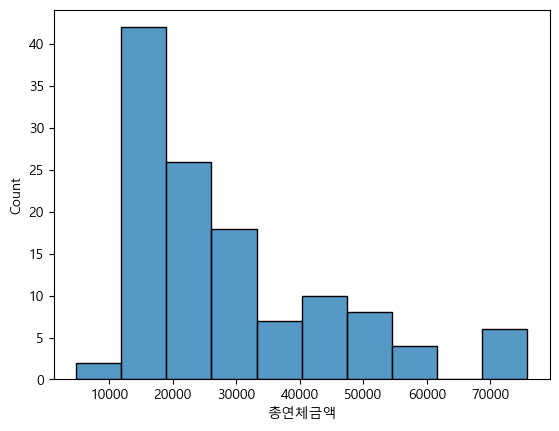

In [ ]:
sns.histplot(data=X_train[X_train['총연체금액']!=0], x='총연체금액')

### 학습 모델을 이용한 스케일링
- 수치형 데이터: '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
- 표준화(sd_sc): '연간소득'?, '부채_대비_소득_비율'? ->조금 애매함 튜터님과 상의
- 정규화(mm_sc): '대출금액', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'

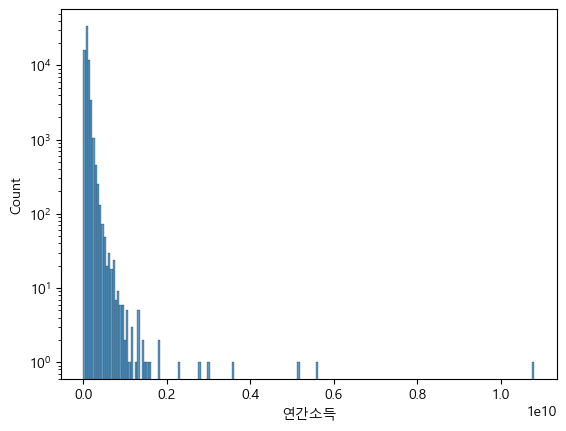

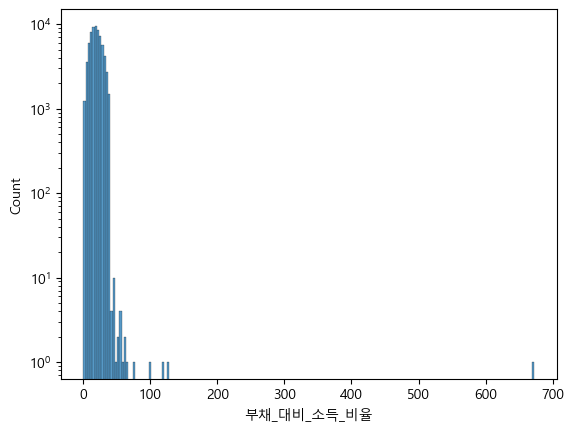

In [ ]:
for plot_col in ['연간소득', '부채_대비_소득_비율']:
    sns.histplot(X_train, x=plot_col, bins=200)
    plt.yscale('log')  # y축을 로그 스케일로 변환
    plt.show()

In [ ]:
def get_numeric_sc(X_train:pd.DataFrame, X_test:pd.DataFrame):
    """데이터를 전달받아 수치형 변수 스케일링하는 함수

    Args:
        X_train (pd.DataFrame): train 데이터프레임
        X_test (pd.DataFrame):  test 데이터프레임

    Returns:
        pd.DataFrame, pd.DataFrame: train, test 데이터프레임
    """
    # 수치형변수
    # '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
    #StandardScaler 적용할 변수 리스트
    sc_col = ['연간소득', '부채_대비_소득_비율']
    #MinMaxScaler 적용할 변수 리스트
    mm_col = ['대출금액', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
    
    #모델 가져오기
    sd_sc = StandardScaler()
    mm_sc = MinMaxScaler()

    #train, test 데이터변환(Standard Scaler이용)
    sd_sc.fit(X_train[sc_col])
    X_train[sc_col] = sd_sc.transform(X_train[sc_col])  #컬럼추가안해주고 바로 바꾸는지?
    X_test[sc_col] = sd_sc.transform(X_test[sc_col])
    
    #train, test 데이터변환(MinMax Scaler이용)
    mm_sc.fit(X_train[mm_col])
    X_train[mm_col] = mm_sc.transform(X_train[mm_col])
    X_test[mm_col] = mm_sc.transform(X_test[mm_col])
    
    return X_train, X_test

## 인코딩
- y 변수 인코딩: 
- 순서가 중요한 순서형 데이터: (map이나 다른 패키지의 모듈 사용)
- 레이블 인코딩: 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
- 원-핫 인코딩 : 주택소유상태, 대출목적
	- get_dummy:
	- 원-핫 인코딩:

### y 변수 인코딩
일단은 dict와 map을 이용해서 인코딩해주었음     
매칭시켜준 값은 y_dict = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}로 임시로 해뒀음 -> 더 좋은 아이디어가 있을지?

In [ ]:
# 일단 y값 어떤 것이 있는지 다시 확인
print(y_train.value_counts())
print(y_train.info())

대출등급
B       20171
C       19336
A       11740
D        9348
E        5148
F        1368
G         294
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 67405 entries, 42717 to 33408
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   대출등급    67405 non-null  category
dtypes: category(1)
memory usage: 592.8 KB
None


In [ ]:
# y 변수 인코딩 함수
# def get_multiple_categories(x):

# y값 매칭해줄 정보 딕셔너리    
y_dict = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}
    
# 확인용 미리 저장
#y_train_original = y_train.copy()
#y_test_original = y_test.copy()

# y_train 데이터 인코딩 코드
y_train['대출등급_en'] = y_train['대출등급'].map(y_dict)
# y_test 데이터 인코딩코드
#y_test['y'] = y_test['y'].apply(get_binary)

#잘 적용되었는지 확인 #df 표기법 헷깔려서 찾아봐야함
# display(y_train[][10:21])
# display(y_train[10:21])

In [ ]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67405 entries, 42717 to 33408
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   대출등급     67405 non-null  category
 1   대출등급_en  67405 non-null  category
dtypes: category(2)
memory usage: 658.9 KB


### 범주형 데이터 전처리 (인코딩)
- 범주형 데이터: '대출기간', '근로기간', '주택소유상태', '대출목적'   
우선적으로 그냥 get_dummies로 하고 시간 여유가 된다면 후에 더 건드려볼듯 함	
	
- 순서가 중요한 순서형 데이터 (map이나 다른 패키지의 모듈 사용(from category_encoders import OrdinalEncoder)) : 	
	- 대출기간, 근로기간 정도 생각은 하고 있음
- 레이블 인코딩(le): 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
- 원-핫 인코딩(oe): 주택소유상태, 대출목적	
	둘중 하나로 통일해서 전부 해볼 듯하다   
	- get_dummy:
	- 원-핫 인코딩:

In [ ]:
def get_category(train:pd.DataFrame, test:pd.DataFrame):
    """ 데이터를 전달받아 범주형 변수 더미화하는 함수

    Args:
        X_train (pd.DataFrame): train 데이터프레임
        X_test (pd.DataFrame):  test 데이터프레임
        # 컬럼 리스트를 4가지로 받아서 각 순서, 레이블, get_dummies, 원핫으로 사용할 수 있게 구현시켜볼 예정
    Returns:
        pd.DataFrame, pd.DataFrmae, list: train, test 데이터프레임, 더미화된 컬럼
    """
    
# 이부분 입력인자랑 전역변수랑 이름 중복되서 살짝 신경쓰임 나중에 시간 날때 수정해보던가 하기
    #범주형변수
    # 'job','marital','education','default','housing','loan','contact','month','poutcome'
    
    # le = LabelEncoder()
    # le2 = LabelEncoder()
    # le3 = LabelEncoder()
    
    # le.fit(X_train[['marital']])
    # X_train['marital'] = le.transform(X_train[['marital']])
    # X_test['marital'] = le.transform(X_test[['marital']])
    
    # le2.fit(X_train[['education']])
    # X_train['education'] = le2.transform(X_train[['education']])
    # X_test['education'] = le2.transform(X_test[['education']])
    
    # le3.fit(X_train[['month']])
    # X_train['month'] = le3.transform(X_train[['month']])
    # X_test['month'] = le3.transform(X_test[['month']])
    
    # dumies_col = ['job','default','housing','loan','contact','poutcome'] #더미할 컬럼
    
    # #범주형 컬럼 더미화 하기
    # X_train_dummies = pd.get_dummies(X_train[dumies_col])
    # X_test_dummies = pd.get_dummies(X_test[dumies_col])
    
    #범주형 컬럼 더미화 하기
    train_dummies = pd.get_dummies(train[category_col])
    test_dummies = pd.get_dummies(test[category_col])
    
    # 더미화한 변수를 기존 데이터셋에 합치기
    train = pd.concat([train, train_dummies], axis = 1)
    test = pd.concat([test, test_dummies], axis = 1)
    
    return train, test, train_dummies.columns.to_list()

# 모델 수립 및 평가
- 모델은 후보로 염두 중인 것은 로지스터 회귀, 의사결정나무, 랜덤포레스트, knn(최근접이웃), Gradient Boosting, XGBoost, LightGBM     
    ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']
- 우선 일반적으로 이진분류에서 사용하는 평가지표인 <u>정확도</u>, 정밀도, 재현율, <u>F1 점수</u> 사용을 할 것이지만 
    보통 다중 분류에서는 각 클래스에 대한 지표를 계산한 후 평균 내는 방법 등이 추가로 필요하다고 하여 추가 조사 필요
- 전체적으로 다중 분류의 경우 아래와 같이 본 설명이 있어 추가로 이진분류와 어떻게 추가로 다르게 해줘야하는지는 찾아보아야 함
    * 레이블 처리: 이진 분류에서는 대상 변수가 두 가지 범주로 나뉘지만, 다중 분류에서는 대상 변수가 세 개 이상의 범주로 나뉩니다. 따라서 다중 분류 문제에서는 레이블을 적절히 처리해야 합니다.    
    * 성능 측정: 이진 분류에서는 정확도, 정밀도, 재현율, F1 점수 등을 사용하여 모델의 성능을 측정합니다. 다중 분류에서도 이러한 지표를 사용할 수 있지만, 각 클래스에 대한 지표를 계산한 후 이를 평균내는 방법 등이 추가로 필요합니다.     
    * 확률 추정: 일부 알고리즘(예: 로지스틱 회귀)은 이진 분류에서는 시그모이드 함수를, 다중 분류에서는 소프트맥스 함수를 사용하여 클래스 확률을 추정합니다.
    * 손실 함수: 일부 알고리즘(예: SVM, 신경망)은 이진 분류와 다중 분류에서 다른 손실 함수를 사용합니다.

rt의 경우 변수별 중요도를 추출할 수 있어서 그것을 통해 그래프 그리는 기능 추가시켜뒀음

### 변수 중요도 그래프 그리기(함수형태)

In [ ]:
# 변수 중요도 그래프 그리기
def draw_feature_importances(feature_importances_df, width_ratios=[3, 1], fontsize=10):
    import matplotlib.gridspec as gridspec
    # Create a figure object
    f = plt.figure(figsize=(15,20))
    
    # Create a gridspec object
    gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios)  # Here, ax1 is three times wider than ax2

    # Create axes using the gridspec object
    ax1 = f.add_subplot(gs[0])
    ax2 = f.add_subplot(gs[1])

    # 레이아웃 조정
    f.subplots_adjust(wspace=0.05)

    # xaxis grid 만들기
    ax1.xaxis.grid()
    ax2.xaxis.grid()

    # 각각의 subplot ax1과 ax2에 barplot 그리기
    ax1 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax1)
    ax2 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax2)
    
    # 각 서브플롯에 대해 막대그래프 끝에 값을 표시
    for p in ax1.patches:
        ax1.annotate(format(p.get_width(), '.4f'), 
                    (p.get_x() + p.get_width(), p.get_y()), 
                    xytext=(0, -9), 
                    textcoords='offset points',
                    ha='left', 
                    va='center', 
                    fontsize=fontsize)

    for p in ax2.patches:
        ax2.annotate(format(p.get_width(), '.4f'), 
                    (p.get_x() + p.get_width(), p.get_y()), 
                    xytext=(0, -9), 
                    textcoords='offset points',
                    ha='left', 
                    va='center', 
                    fontsize=fontsize)
    
    # 축 폰트 크기 설정
    ax1.tick_params(axis='both', labelsize=fontsize*1.2)  # 폰트 크게 조절 #실수float 가능
    ax2.tick_params(axis='both', labelsize=fontsize*1.2)  # 폰트 크게 조절

    # 각 subplot의 축범위 설정 (자동화 가능)
    ax1.set_xlim(0, max(feature_importances_df['importances'])/2)
    ax2.set_xlim(max(feature_importances_df['importances'])/2, max(feature_importances_df['importances']))

    # 각 subplot 눈금 표시하기
    ax1.set_xticks([i/100 for i in range(0, int(max(feature_importances_df['importances'])*100/2), 2)])  # 눈금 간격을 일정하게 조절
    ax2.set_xticks([i/100 for i in range(int(max(feature_importances_df['importances'])*100/2), int(max(feature_importances_df['importances'])*100), 2)])

    # x축 이름 없애줬음 통합해서 붙여줘야함
    ax1.set_xlabel("")
    ax2.set_xlabel("")  # x축 라벨 가운데 정렬

    # x축 label 가운데 위치
    f.text(0.5, 0.08, 'Importances', ha='center', va='center', fontsize=20)
    
    # y축 라벨 설정
    ax1.set_ylabel("Feature Names", fontsize=fontsize*1.4)
    ax2.set_ylabel("")

    # 서로 만나는 부분 y축 선 안보이게 제거
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # 오른 쪽 것의 y축 제거
    ax2.get_yaxis().set_visible(False)

    # 대각선 생략표시
    d = .9    
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', clip_on=False)
    ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

    # y축 값 표시
    ax1.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
    ax2.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
    # y축 눈금 간격 조정
    plt.yticks(fontsize=fontsize*1.2, rotation=30)
    
    # 그래프 제목
    plt.suptitle('Feature Importances', fontsize=fontsize*3, y=0.92)  # 제목 폰트 크게 조절
    
    # 그래프 표시
    plt.show()

# 이제 함수를 호출하여 그래프를 그릴 수 있습니다.


## 모델 적용 및 평가 함수

In [ ]:
def get_score(train:pd.DataFrame,  test:pd.DataFrame, x_var_list:list, model_type:str = 'rf'):
    """ train과 test 데이터와 X변수 컬럼을 받아 평가지표를 내는 함수입니다.

    Args:
        train (pd.DataFrame): train 데이터프레임
        test (pd.DataFrame): test 데이터프레임
        x_var_list (list): 모델링에 사용할 변수 리스트
        model_type(str) : 무슨 모델 쓸지 결정 (default : 'rf')
    """
    #외부 전달인자를 내부변수에 할당
    X_train = train 
    X_test = test

    #일부 컬럼만 가져오기
    X_train = X_train[x_var_list]
    X_test = X_test[x_var_list]
    
    #모델가져오기 & 학습하기    &   # 학습하여 결과 저장
    if model_type in ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']:
        if model_type == 'lor':
            from sklearn.linear_model import LogisticRegression
            model_lor = LogisticRegression()
            model_lor.fit(X_train, y_train)
            y_pred_train = model_lor.predict(X_train)
            y_pred_test = model_lor.predict(X_test)
            
        elif model_type == 'dt':
            from sklearn.tree import DecisionTreeClassifier
            model_dt = DecisionTreeClassifier(random_state=42)
            model_dt.fit(X_train, y_train)
            y_pred_train = model_dt.predict(X_train)
            y_pred_test = model_dt.predict(X_test)
            
        elif model_type == 'rf':
            from sklearn.ensemble import RandomForestClassifier
            model_rf = RandomForestClassifier(random_state=42)
            model_rf.fit(X_train, y_train)
            y_pred_train = model_rf.predict(X_train)
            y_pred_test = model_rf.predict(X_test)
            
            # 변수별 중요도 표시
            feature_names = model_rf.feature_names_in_
            feature_importances = model_rf.feature_importances_
            feature_importances_df = pd.DataFrame({"name": feature_names, "importances": feature_importances})
            #display(feature_importances_df)
            
            # 함수 기능 개선하다가 뭐 잘못조절했는지 자르고나서 큰값 나머지 부분이 그려져야하는데 안그려지는 오류있어서 주석처리해둠
            # 개선 예정
            # import matplotlib.gridspec as gridspec

            # # Create a figure object
            # f = plt.figure(figsize=(15,20))
            
            # # Create a gridspec object
            # gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # Here, ax1 is three times wider than ax2

            # # Create axes using the gridspec object
            # ax1 = f.add_subplot(gs[0])
            # ax2 = f.add_subplot(gs[1])

            # # 레이아웃 조정
            # f.subplots_adjust(wspace=0.05)

            # # xaxis grid 만들기
            # ax1.xaxis.grid()
            # ax2.xaxis.grid()

            # # 각각의 subplot ax1과 ax2에 barplot 그리기
            # ax1 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax1)
            # ax2 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax2)
            
            # # 각 서브플롯에 대해 막대그래프 끝에 값을 표시
            # for p in ax1.patches:
            #     ax1.annotate(format(p.get_width(), '.4f'), 
            #                 (p.get_x() + p.get_width(), p.get_y()), 
            #                 xytext=(0, -9), 
            #                 textcoords='offset points',
            #                 ha='left', 
            #                 va='center', 
            #                 fontsize=10)

            # for p in ax2.patches:
            #     ax2.annotate(format(p.get_width(), '.4f'), 
            #                 (p.get_x() + p.get_width(), p.get_y()), 
            #                 xytext=(0, -9), 
            #                 textcoords='offset points',
            #                 ha='left', 
            #                 va='center', 
            #                 fontsize=10)
            
            # # 축 폰트 크기 설정
            # ax1.tick_params(axis='both', labelsize=12)  # 폰트 크게 조절
            # ax2.tick_params(axis='both', labelsize=12)  # 폰트 크게 조절

            # # 각 subplot의 축범위 설정 (자동화 가능)
            # ax1.set_xlim(0, 0.09)
            # ax2.set_xlim(0.32, 0.34)

            # # 각 subplot 눈금 표시하기
            # ax1.set_xticks([0, 0.02, 0.04, 0.06, 0.08])  # 눈금 간격을 일정하게 조절
            # ax2.set_xticks([0.32, 0.34])

            # # x축 이름 없애줬음 통합해서 붙여줘야함
            # ax1.set_xlabel("")
            # ax2.set_xlabel("")  # x축 라벨 가운데 정렬

            # # x축 label 가운데 위치
            # f.text(0.5, 0.08, 'Importances', ha='center', va='center', fontsize=20)
            
            # # y축 라벨 설정
            # ax1.set_ylabel("Feature Names", fontsize=14)
            # ax2.set_ylabel("")

            # # 서로 만나는 부분 y축 선 안보이게 제거
            # ax1.spines['right'].set_visible(False)
            # ax2.spines['left'].set_visible(False)

            # # 오른 쪽 것의 y축 제거
            # ax2.get_yaxis().set_visible(False)

            # # 대각선 생략표시
            # d = .99    
            # kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', clip_on=False)
            # ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
            # ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

            # # y축 값 표시
            # ax1.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
            # ax2.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
            # # y축 눈금 간격 조정
            # plt.yticks(fontsize=12, rotation=30)
            
            # # 그래프 제목
            # plt.suptitle('Feature Importances', fontsize=30, y=0.92)  # 제목 폰트 크게 조절
            
            # # 그래프 표시
            # plt.show()
            #draw_feature_importances(feature_importances_df)
            
        elif model_type == 'knn':
            from sklearn.neighbors import KNeighborsClassifier
            model_knn = KNeighborsClassifier()
            model_knn.fit(X_train, y_train)
            y_pred_train = model_knn.predict(X_train)
            y_pred_test = model_knn.predict(X_test)
            
        elif model_type == 'gbm':
            from sklearn.ensemble import GradientBoostingClassifier
            model_gbm = GradientBoostingClassifier(random_state= 42)
            model_gbm.fit(X_train, y_train)
            y_pred_train = model_gbm.predict(X_train)
            y_pred_test = model_gbm.predict(X_test)
            
        elif model_type == 'xgb':
            from xgboost import XGBClassifier
            model_xgb = XGBClassifier(random_state= 42)
            model_xgb.fit(X_train, y_train)
            y_pred_train = model_xgb.predict(X_train)
            y_pred_test = model_xgb.predict(X_test)
            
        elif model_type == 'lgb':
            from lightgbm import LGBMClassifier
            model_lgb = LGBMClassifier(random_state= 42)
            model_lgb.fit(X_train, y_train)
            y_pred_train = model_lgb.predict(X_train)
            y_pred_test = model_lgb.predict(X_test)
    
    #평가표 생성
    result = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train), f1_score(y_test, y_pred_test)]},
                            index = ['train','test'])
    
    print(model_type,"사용시")
    display(result.round(5))

## 전체 모델링 및 평가
- 하기전에 전처리등 test 데이터에도 동일하게 해줬는지 생각(결측치 등은 몇몇부분은 안해줘야할 것 같기도한데 그부분은 좀더 고민)

#### 위에서 만들어 둔 스케일링과 인코딩 적용

In [ ]:
# X_train, X_test = get_numeric_sc(X_train, X_test)
# X_train, X_test, col_dummies = get_category(X_train,X_test)

#### 모델별 학습 및 평가

In [ ]:
# for model in ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']:
#     get_score(X_train, X_test, col_dummies + numeric_col, model_type=model)
# get_score(X_train, X_test, col_dummies + numeric_col, model_type='rf')

# 추가로 고려해야할 부분

이상치로 판단되어 제외해줬던 부채_대비_소득 비율 9999.0이였던 사람이 

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>대출금액</th>
      <th>대출기간</th>
      <th>근로기간</th>
      <th>주택소유상태</th>
      <th>연간소득</th>
      <th>부채_대비_소득_비율</th>
      <th>총계좌수</th>
      <th>대출목적</th>
      <th>최근_2년간_연체_횟수</th>
      <th>총상환원금</th>
      <th>총상환이자</th>
      <th>총연체금액</th>
      <th>연체계좌수</th>
      <th>대출등급</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>12498</th>
      <td>4440000</td>
      <td>36 months</td>
      <td>Unknown</td>
      <td>MORTGAGE</td>
      <td>0</td>
      <td>9999.0</td>
      <td>20</td>
      <td>신용 카드</td>
      <td>2</td>
      <td>205356</td>
      <td>85884.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>C</td>
    </tr>
  </tbody>
</table>
</div>

라는 이상한 형태였다는 것? -> 연간 소득이 0이라서 그리 큰값이 나온듯했음    
연간소득 0 인 사람 저 사람 혼자뿐 그리고 그외 최소 연간소득이 1440000이였음